# 08. Integration of Experimental Data

## Numerical experiments - Week 04/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## Prerequisite libraries

In [1]:
using CSV
using DataFrames
using PyPlot
using Revise
# using StatsPlots

include("./conversions.jl")
using .Conversions

## 1. Reading the germination data from Ijadpanahsaravi (2024)

There are two relevant data sets available from [1]. First, there are the results from incrementally increased inoculum sizes from 5000 to 40000 conidia per $150\mu\textrm{L}$ solution under different inducing carbon sources. A second series of experiments focuses on the two extremes of this conidial density range. The data from the `.csv` files is first parsed to extract two main measurements of interest - the incidence of swelling ($P_{\textrm{max}}$) and the corresponding half-saturation time $\tau$.

New clean data frames for the two experiments are created with a shared format, which includes:

Carbon source|Density | $\langle P_{\textrm{max}}\rangle$ | $\textrm{CI}_{\textrm{low}}$ ($P_{\textrm{max}}$) | $\textrm{CI}_{\textrm{high}}$ ($P_{\textrm{max}}$)|$\langle\tau\rangle$| $\textrm{CI}_{\textrm{low}}$ ($\tau$) | $\textrm{CI}_{\textrm{high}}$ ($\tau$)|N|M
---|--------------------------------|-----|----|---|---|---|---|---|---
...|...                             | ... | ...|...|...|...|...|...|...

In [13]:
df_germination = DataFrame(CSV.File("Data/swelling_germination_results.csv"; header=true))
df_germination_extremes = DataFrame(CSV.File("Data/swelling_germination_results_extreme_densities.csv"))

# ===== Filter data from germination with many densities =====

# Filter the data to only include swelling
df_germination_swelling = filter(row -> row[1] == "Swelling", df_germination)

# Expression for parsing
regex_triplet = r"(-?\d+\.\d+)\[(-?\d+\.\d+);(-?\d+\.\d+)\]*.*"

# Function to parse a string and return three numbers
function parse_numbers(s)
    m = match(regex_triplet, s)
    if m !== nothing
        num1 = parse(Float64, m.captures[1])
        num2 = parse(Float64, m.captures[2])
        num3 = parse(Float64, m.captures[3])
        return num1, num2, num3
    else
        return missing, missing, missing
    end
end

# Parse Pmax and its confidence intervals
Pmax_parsed = [parse_numbers(row[1]) for row in eachrow(df_germination_swelling[!, 4])]
Pmax_vals = [x[1] for x in Pmax_parsed]
PmaxCIlow_vals = [x[2] for x in Pmax_parsed]
PmaxCIhigh_vals = [x[3] for x in Pmax_parsed]

# Parse tau and its confidence intervals
tau_parsed = [parse_numbers(row[1]) for row in eachrow(df_germination_swelling[!, 5])]
tau_vals = [x[1] for x in tau_parsed]
tauCIlow_vals = [x[2] for x in tau_parsed]
tauCIhigh_vals = [x[3] for x in tau_parsed]

# Reconstruct the DataFrame with the parsed values
df_germination_rebuilt = DataFrame(
    :CarbonSource => df_germination_swelling[!, 2],
    :Density => inverse_uL_to_mL(df_germination_swelling[!, 3] / 150),
    :Pmax => Pmax_vals,
    :Pmax_CI_Lower => PmaxCIlow_vals,
    :Pmax_CI_Upper => PmaxCIhigh_vals,
    :tau => tau_vals,
    :tau_CI_Lower => tauCIlow_vals,
    :tau_CI_Upper => tauCIhigh_vals,
    :N => df_germination_swelling[!, 8],
    :M => df_germination_swelling[!, 9]
)

# ===== Filter data from germination with extreme densities =====

# Find the first row that contains only missing values
first_missing_row_index = findfirst(row -> all(ismissing, row), eachrow(df_germination_extremes))

# Filter rows preceding the first row with all missing elements
if first_missing_row_index !== nothing
    preceding_rows = df_germination_extremes[1:first_missing_row_index-1, :]
else
    preceding_rows = df_germination_extremes
end

# Further filter these rows to include only those where the string in the first column starts with "A"
df_germination_extremes_swelling = filter(row -> startswith(row[1], "A"), preceding_rows)

# Parse density values
regex_single = r"\((\d+)\)"
function parse_density(s)
    m = match(regex_single, s)
    if m !== nothing
        return parse(Int, m.captures[1])
    else
        return missing
    end
end
density_vals = [inverse_uL_to_mL(parse_density(row[1])/150) for row in eachrow(df_germination_extremes_swelling)]

# Expression for parsing
regex_triplet = r"(-?\d+\.\d+) \[(-?\d+\.\d+);(-?\d+\.\d+)\]*.*"

# Parse Pmax and its confidence intervals
Pmax_parsed = [parse_numbers(row[3]) for row in eachrow(df_germination_extremes_swelling)]
Pmax_vals = [x[1] for x in Pmax_parsed]
PmaxCIlow_vals = [x[2] for x in Pmax_parsed]
PmaxCIhigh_vals = [x[3] for x in Pmax_parsed]

# Parse tau and its confidence intervals
tau_parsed = [parse_numbers(row[4]) for row in eachrow(df_germination_extremes_swelling)]
tau_vals = [x[1] for x in tau_parsed]
tauCIlow_vals = [x[2] for x in tau_parsed]
tauCIhigh_vals = [x[3] for x in tau_parsed]

# Reconstruct the DataFrame with the parsed values
df_germination_extremes_rebuilt = DataFrame(
    :CarbonSource => df_germination_extremes_swelling[!, 2],
    :Density => density_vals,
    :Pmax => Pmax_vals,
    :Pmax_CI_Lower => PmaxCIlow_vals,
    :Pmax_CI_Upper => PmaxCIhigh_vals,
    :tau => tau_vals,
    :tau_CI_Lower => tauCIlow_vals,
    :tau_CI_Upper => tauCIhigh_vals,
    :N => df_germination_extremes_swelling[!, 5],
    :M => df_germination_extremes_swelling[!, 6]
)

df_germination_rebuilt

Row,CarbonSource,Density,Pmax,Pmax_CI_Lower,Pmax_CI_Upper,tau,tau_CI_Lower,tau_CI_Upper,N,M
,String3,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64
1,Ala,33333.3,95.98,92.44,99.51,6.93,6.59,7.26,373,10
2,Ala,66666.7,90.81,86.43,95.18,5.28,4.84,5.72,979,37
3,Ala,1.33333e5,84.14,78.58,89.69,5.77,5.17,6.37,1112,66
4,Ala,2.66667e5,71.91,61.67,82.14,6.31,5.06,7.57,1301,89
5,Arg,33333.3,25.06,-0.83,50.96,15.0,1.47,28.53,626,94
6,Arg,66666.7,16.61,5.63,27.6,15.0,7.02,22.98,1026,19
7,Arg,1.33333e5,13.69,4.32,23.05,15.0,-0.44,30.44,1372,14
8,Arg,2.66667e5,11.25,-1.93,24.43,15.0,-12.95,42.95,1408,105
9,Pro,33333.3,94.95,91.22,98.69,4.55,4.19,4.91,526,7


## 2. Visualising the Swelling Incidence With Respect to Spore Density

The saturation limit $P_{\textrm{max}}$ is plotted against the corresponding densities from the first and the second experiment.

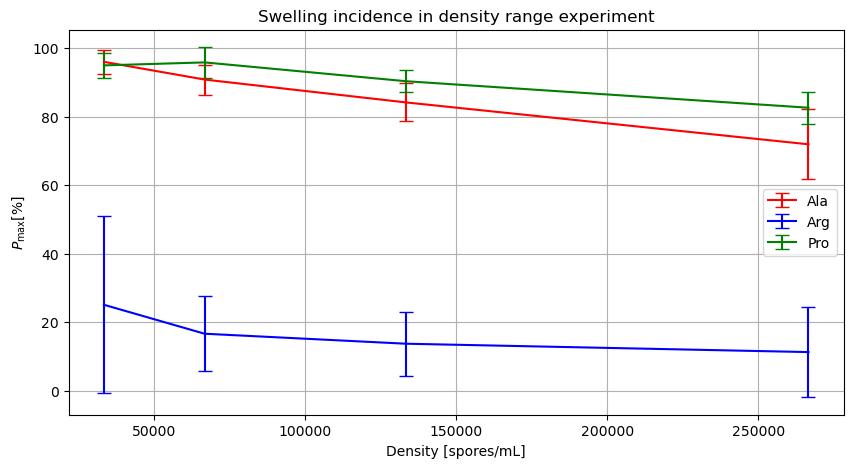

In [70]:
# ===== Plot full density range =====

# Define a color map for the CarbonSource column
unique_sources = unique(df_germination_rebuilt.CarbonSource)
color_map = Dict(source => color for (source, color) in zip(unique_sources, ["red", "blue", "green", "orange", "purple", "brown"]))

# Assign colors based on the CarbonSource column
colors = [color_map[source] for source in df_germination_rebuilt.CarbonSource]

# Create the plot
fig = figure(figsize=(10, 5))
carbon_srcs = unique(df_germination_rebuilt[!, :CarbonSource])
for src in carbon_srcs
    df_src = filter(row -> row[1] == src, df_germination_rebuilt)

    err_lo = df_src[!, :Pmax]-df_src[!, :Pmax_CI_Lower]
    err_lo[err_lo .< 0] .= 0
    err_hi = df_src[!, :Pmax_CI_Upper]-df_src[!, :Pmax]
    errorbar(df_src[!, :Density], df_src[!, :Pmax], yerr=[err_lo, err_hi],
            fmt=:"", color=color_map[src], ecolor=color_map[src], capsize=5, label=src)
end

# Add labels and title
xlabel("Density [spores/mL]")
ylabel(L"P_\text{max}[\%]")
title("Swelling incidence in density range experiment")
legend()
grid()

# Show the plot
show()
gcf()

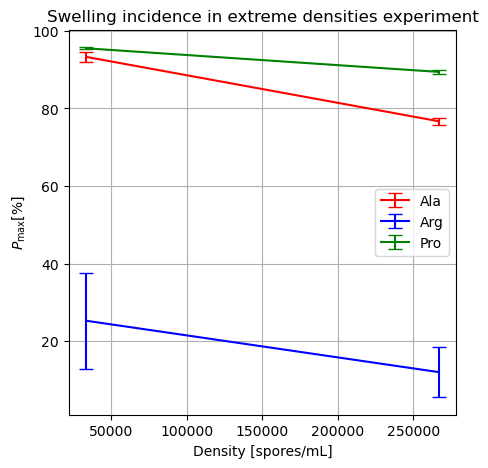

In [71]:
# ===== Plot density extremes =====

# Assign colors based on the CarbonSource column
colors = [color_map[source] for source in df_germination_extremes_rebuilt.CarbonSource]

# Create the plot
fig = figure(figsize=(5, 5))
carbon_srcs = unique(df_germination_extremes_rebuilt[!, :CarbonSource])
for src in carbon_srcs
    df_src = filter(row -> row[1] == src, df_germination_extremes_rebuilt)

    err_lo = df_src[!, :Pmax]-df_src[!, :Pmax_CI_Lower]
    err_lo[err_lo .< 0] .= 0
    err_hi = df_src[!, :Pmax_CI_Upper]-df_src[!, :Pmax]
    errorbar(df_src[!, :Density], df_src[!, :Pmax], yerr=[err_lo, err_hi],
            fmt=:"", color=color_map[src], ecolor=color_map[src], capsize=5, label=src)
end

# Add labels and title
xlabel("Density [spores/mL]")
ylabel(L"P_\text{max}[\%]")
title("Swelling incidence in extreme densities experiment")
legend()
grid()

# Show the plot
show()
gcf()

## 3. Visualising the Swelling Time With Respect to Spore Density

The swelling half-saturation time $\tau$ is plotted against the corresponding densities from the first and the second experiment.

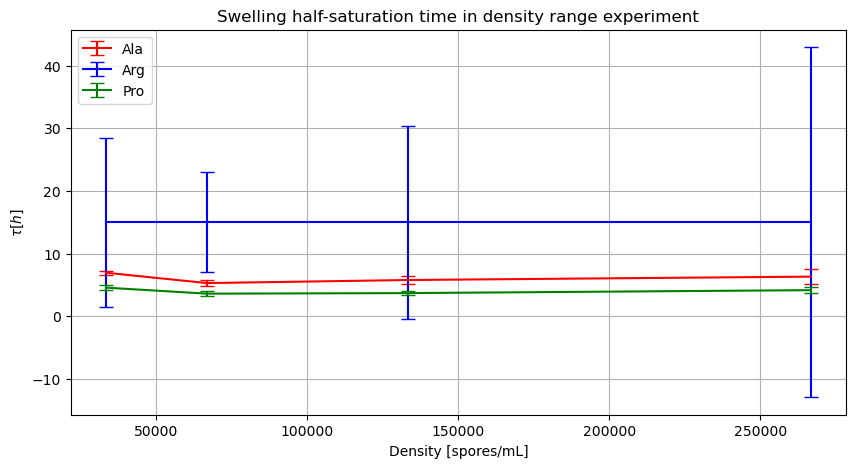

In [72]:
# ===== Plot full density range =====

# Assign colors based on the CarbonSource column
colors = [color_map[source] for source in df_germination_rebuilt.CarbonSource]

# Create the plot
fig = figure(figsize=(10, 5))
carbon_srcs = unique(df_germination_rebuilt[!, :CarbonSource])
for src in carbon_srcs
    df_src = filter(row -> row[1] == src, df_germination_rebuilt)

    err_lo = df_src[!, :tau]-df_src[!, :tau_CI_Lower]
    err_lo[err_lo .< 0] .= 0
    err_hi = df_src[!, :tau_CI_Upper]-df_src[!, :tau]
    errorbar(df_src[!, :Density], df_src[!, :tau], yerr=[err_lo, err_hi],
            fmt=:"", color=color_map[src], ecolor=color_map[src], capsize=5, label=src)
end

# Add labels and title
xlabel("Density [spores/mL]")
ylabel(L"\tau[h]")
title("Swelling half-saturation time in density range experiment")
legend()
grid()

# Show the plot
show()
gcf()

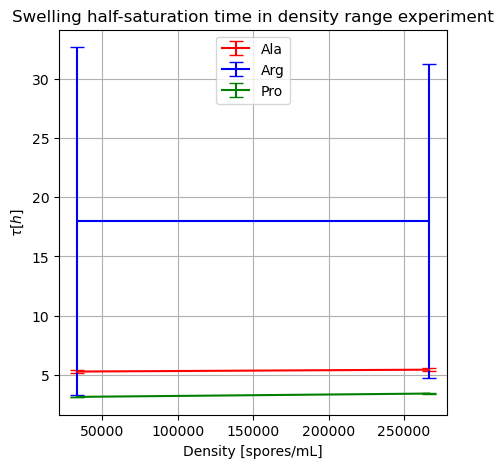

In [75]:
# ===== Plot extreme densities =====

# Assign colors based on the CarbonSource column
colors = [color_map[source] for source in df_germination_extremes_rebuilt.CarbonSource]

# Create the plot
fig = figure(figsize=(5, 5))
carbon_srcs = unique(df_germination_extremes_rebuilt[!, :CarbonSource])
for src in carbon_srcs
    df_src = filter(row -> row[1] == src, df_germination_extremes_rebuilt)

    err_lo = df_src[!, :tau]-df_src[!, :tau_CI_Lower]
    err_lo[err_lo .< 0] .= 0
    err_hi = df_src[!, :tau_CI_Upper]-df_src[!, :tau]
    errorbar(df_src[!, :Density], df_src[!, :tau], yerr=[err_lo, err_hi],
            fmt=:"", color=color_map[src], ecolor=color_map[src], capsize=5, label=src)
end

# Add labels and title
xlabel("Density [spores/mL]")
ylabel(L"\tau[h]")
title("Swelling half-saturation time in density range experiment")
legend()
grid()

# Show the plot
show()
gcf()

## References

- [1] Ijadpanahsaravi, Maryam, L. Basten Snoek, Wieke R. Teertstra and Han A. B. Wösten. “The impact of inter- and intra-species spore density on germination of the food spoilage fungus Aspergillus niger.” _International journal of food microbiology_ 410 (2023): 110495 .